Imagine that we are a data scientist working in a sports betting company.

The business executives in our company identified betting on soccer as a potential new business opportunity.

<div style=display: flex; justify-content: center;>
    <img width=400px height=auto src=https://images.unsplash.com/photo-1489944440615-453fc2b6a9a9?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1482&q=80 />
</div>

The problem is that our company doesn't know a lot about soccer (European football). Our manager asked we to analyse this dataset and see if we can provide anything that could give us a competitive advantage in the attempt to start strong in the new endevor.

We will split our analysis in various sections, therefore:

- [Data Extraction and Cleaning](#Data-Extraction-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Statistical Inference](#Statistical-Inference)
- [Linear Model predictions](#Linear-Model-predictions)
- [Conclusions](#conclusions)

# Data Extraction and Cleaning:

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from queries.sql_queries import *
from py_utilities.plotting import Plotter
from py_utilities.data_cleaner import calculate_stats_both_teams, DataCleaner
from py_utilities.model_fitting import ModelFitter
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy
from sklearn.metrics import roc_curve, roc_auc_score
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=6, split_factor=4, disable_pr_bar=True)

import warnings
warnings.filterwarnings('ignore')

Invoking init.py functions for py_utilities


In [2]:
con = sqlite3.connect('data/raw_data/database.sqlite')

# Check the available tables
tables = pd.read_sql("""
    SELECT * FROM sqlite_master 
    WHERE TYPE = 'table' """,con)

tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


![Database Schema](data/raw_data/database_schema.png)

Judging by the outputs from the metadata, we have a total of 7 tables:

- League
- Country
- Team
- Match
- Player
- Player_Attributes
- Team_Attributes

Let's now try to answer some basic questions.

### Which leagues are in which countries?

We need to obtain the name of the leagues, as well as those of the countries in which each league is located.

In [3]:
leagues_countries_df = pd.read_sql_query(leagues_country, con)
leagues_countries_df

,first_word,second_word
0,Belgium,Jupiler League
1,England,Premier League
2,France,Ligue 1
3,Germany,1. Bundesliga
4,Italy,Serie A
5,Netherlands,Eredivisie
6,Poland,Ekstraklasa
7,Portugal,Liga ZON Sagres
8,Scotland,Premier League
9,Spain,LIGA BBVA


### Which leagues score the most/fewest goals?

Once again, we retrieve the names of the leagues, and this time we also make a calculation on the Match tables for obtaining the cumulative number of goals scored.

In [4]:
league_num_goals = pd.read_sql_query(league_num_goals, con)
league_num_goals

,Country,League,TotalGoals
0,Spain,LIGA BBVA,8412
1,England,Premier League,8240
2,Italy,Serie A,7895
3,Netherlands,Eredivisie,7542
4,France,Ligue 1,7427
5,Germany,1. Bundesliga,7103
6,Portugal,Liga ZON Sagres,5201
7,Belgium,Jupiler League,4841
8,Scotland,Premier League,4804
9,Poland,Ekstraklasa,4656


### Which teams score the most/fewest goals?

This time, let's see this goals breakdown by teams instead. Let's get the top 10.

In [5]:
teams_goals = pd.read_sql_query(teams_goals, con)
teams_goals.head(10)

,country,team,home_goal,away_goal
0,Spain,Real Madrid CF,505,147
1,Spain,FC Barcelona,495,101
2,Scotland,Celtic,389,88
3,Germany,FC Bayern Munich,382,96
4,Netherlands,PSV,370,126
5,England,Manchester City,365,125
6,Netherlands,Ajax,360,78
7,Switzerland,FC Basel,344,126
8,England,Manchester United,338,120
9,England,Chelsea,333,129


In [6]:
plotter = Plotter()
## TODO: remove outliers
cleaner = DataCleaner()

plotter.plot_regression_correlation(teams_goals, x='home_goal',y='away_goal', title="Home vs. Away Goals")

As we could have imagined, being Spain the country/league with the most goals scored, the teams with the most goals scored are Spanish. Interestingly, although Scotland has one of the leagues with least goals, a Scottish team is top 3 in the list. 

Another interesting aspect is that Italy is 4th in the list of overall goals scored, but no Italian team appears here.

In the regression, we also notice how the amount of away goals increases with the amount of home goals, suggesting stronger teams score more both at home and away. But there's an immediate noticeable effect of Home on the amount of goals scored.

- R^2 : 0.51
- away_goal = 0.37 * home_goal + 50.58 

### What are the best players according to their potential?

In [7]:
players_potential = pd.read_sql_query(players_potential, con)
players_potential.head(10)

,Player_Name,DOB,Age,Height,Weight,Rating,Potential,Preferred_Foot,Attacking_Work_Rate,Defensive_Work_Rate
0,Lionel Messi,24-06-1987,30,170.18,159,94,97,left,medium,low
1,Ronaldinho,21-03-1980,37,182.88,168,91,95,right,medium,low
2,Cristiano Ronaldo,05-02-1985,32,185.42,176,93,95,right,high,low
3,Zlatan Ibrahimovic,03-10-1981,36,195.58,209,90,94,right,medium,low
4,Robinho,25-01-1984,33,175.26,146,87,94,right,high,medium
5,Neymar,05-02-1992,25,175.26,150,90,94,right,high,medium
6,Wayne Rooney,24-10-1985,32,175.26,183,93,93,right,high,high
7,Thierry Henry,17-08-1977,40,187.96,183,91,93,right,medium,low
8,Theo Walcott,16-03-1989,28,175.26,150,82,93,left,high,medium
9,Sergio Aguero,02-06-1988,29,172.72,163,88,93,left,high,low


In [8]:
players_potential.describe()

,Age,Height,Weight,Rating,Potential
count,10329.000000,10329.000000,10329.000000,10329.000000,10329.000000
mean,30.009778,181.931281,168.525995,70.708684,76.381257
std,5.303456,6.385365,15.039559,6.982705,6.762662
min,18.000000,157.480000,117.000000,47.000000,51.000000
25%,26.000000,177.800000,159.000000,66.000000,72.000000
50%,30.000000,182.880000,168.000000,71.000000,77.000000
75%,34.000000,185.420000,179.000000,75.000000,81.000000
max,50.000000,208.280000,243.000000,94.000000,97.000000


- The players with the highest potential as of 2016 (the last year of the dataset) are all around 30+ years old;
- An exception is Neymar who was 25 years old at the time;
- The average height is 181cm and average weight 168kg;
- The average Rating and Potential are 70 and 76, signaling the huge gap between top world players and the rest.

In [9]:
# TODO: reverse colour

plotter.plotly_correlation_heatmap(players_potential)

From this correlation heatmap, it is clear that Rating and Potential are highly correlated, let's try to understand this with another linear regression.

In [10]:
plotter.plot_regression_correlation(players_potential, x="Rating", y="Potential", title="Rating vs. Potential of Players")

- R^2 : 0.69
- Potential = 0.80 * Rating + 19.44 

The potential is definitely highly influenced by variations in the Rating.

### Matches dataset 

Let's get ready to capture the final dataset for our analysis, in which we will try to predict match outcomes based on various features. 

We will focus on trying to predict for matches in the English 'Premier League'.

In [11]:
matches_df = pd.read_sql_query(match_analysis, con)
matches_df

,country,league,season,date,home_team_api_id,home_team,away_team_api_id,away_team,home_goal,away_goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,England,Premier League,2008/2009,2008-08-17 00:00:00,10260,Manchester United,10261,Newcastle United,1,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1,England,Premier League,2008/2009,2008-08-16 00:00:00,9825,Arsenal,8659,West Bromwich Albion,1,0,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
2,England,Premier League,2008/2009,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
3,England,Premier League,2008/2009,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
4,England,Premier League,2008/2009,2008-08-17 00:00:00,10252,Aston Villa,8456,Manchester City,4,2,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,England,Premier League,2015/2016,2015-10-17 00:00:00,8466,Southampton,8197,Leicester City,2,2,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>54</comment><stats...
3036,England,Premier League,2015/2016,2015-10-19 00:00:00,10003,Swansea City,10194,Stoke City,0,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>53</comment><stats...
3037,England,Premier League,2015/2016,2015-10-17 00:00:00,8586,Tottenham Hotspur,8650,Liverpool,0,0,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><stats...
3038,England,Premier League,2015/2016,2015-10-17 00:00:00,9817,Watford,9825,Arsenal,0,3,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscom

Well, those columns on 'shoton', 'foul','card' and so on are full of information about the match, but are presented in a format that looks like xml format, therefore we will have to unpack them before proceeding with the analysis.

In [12]:
# The columns with XML content and the new names 
stats_columns = {
    'on_target_shot': 'shoton',
    'off_target_shot': 'shotoff',
    'foul': 'foulcommit',
    'yellow_card': 'card',
    'red_card': 'card',
    'crosses': 'cross',
    'corner': 'corner',
    'possession': 'possession',
}

# Loop through and create the new columns
for new_col, source_col in stats_columns.items():
    home_col = f'{new_col}_home_team'
    away_col = f'{new_col}_away_team'
    
    card_type = 'r' if 'red_card' in new_col else 'y'

    matches_df[[home_col, away_col]] = matches_df[[source_col, 'home_team_api_id', 'away_team_api_id']].apply(lambda x: calculate_stats_both_teams(x[source_col], x['home_team_api_id'], x['away_team_api_id'], card_type=card_type), axis=1, result_type="expand")

# Drop the source columns
matches_df.drop(columns=list(stats_columns.values()) + ['home_team_api_id', 'away_team_api_id'], inplace=True)

Great, now that all the XML data is cleaned, we can proceed with the analysis. Let's check once more that there are no nulls after our transformations.

In [13]:
matches_df['date'] = matches_df['date'].apply(lambda x: x.split()[0])

matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    3040 non-null   object 
 1   league                     3040 non-null   object 
 2   season                     3040 non-null   object 
 3   date                       3040 non-null   object 
 4   home_team                  3040 non-null   object 
 5   away_team                  3040 non-null   object 
 6   home_goal                  3040 non-null   int64  
 7   away_goal                  3040 non-null   int64  
 8   on_target_shot_home_team   3040 non-null   int64  
 9   on_target_shot_away_team   3040 non-null   int64  
 10  off_target_shot_home_team  3040 non-null   int64  
 11  off_target_shot_away_team  3040 non-null   int64  
 12  foul_home_team             3040 non-null   int64  
 13  foul_away_team             3040 non-null   int64

Let's drop the 6 null rows we are left with after our transformations.

In [14]:
matches_df = matches_df.dropna()

cols = set(matches_df.columns) - {'id'}
matches_df_numerical = matches_df[list(cols)]
matches_df_numerical.describe()

,corner_away_team,red_card_home_team,possession_home_team,yellow_card_home_team,crosses_home_team,foul_away_team,on_target_shot_home_team,crosses_away_team,red_card_away_team,off_target_shot_home_team,possession_away_team,home_goal,yellow_card_away_team,on_target_shot_away_team,away_goal,off_target_shot_away_team,foul_home_team,corner_home_team
count,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,4.812129,0.041859,51.676994,1.433092,20.914305,11.400461,6.681279,16.248846,0.053065,6.603823,48.323006,1.552736,1.819710,5.274555,1.158207,5.206328,10.692485,6.126895
std,2.719731,0.205179,8.640939,1.172118,8.737286,3.686908,3.511969,7.376841,0.232857,3.091729,8.640939,1.311651,1.293977,2.936536,1.143808,2.669561,3.548268,3.147969
min,0.000000,0.000000,4.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,0.000000,46.000000,1.000000,15.000000,9.000000,4.000000,11.000000,0.000000,4.000000,43.000000,1.000000,1.000000,3.000000,0.000000,3.000000,8.000000,4.000000
50%,4.000000,0.000000,52.000000,1.000000,20.000000,11.000000,6.000000,15.000000,0.000000,6.000000,48.000000,1.000000,2.000000,5.000000,1.000000,5.000000,11.000000,6.000000
75%,6.000000,0.000000,57.000000,2.000000,26.000000,14.000000,9.000000,21.000000,0.000000,9.000000,54.000000,2.000000,3.000000,7.000000,2.000000,7.000000,13.000000,8.000000
max,19.000000,2.000000,80.000000,7.000000,72.000000,25.000000,26.000000,55.000000,2.000000,21.000000,96.000000,9.000000,9.000000,19.000000,6.000000,19.000000,26.000000,20.000000


We can see from the description of the dataset that:

- Home teams tend to have a higher mean of goal scored than away teams;
- The mean number of fouls committed by the away team is approximately 11.40, whereas on average, the home team commits around 10.69 fouls;
- The mean number of on-target shots by the away team is approximately 5.27, and the home team records about 6.68 mean of on-target shots;
- Lastly, another important measure that the mean possession percentage for the away team is approximately 48.32%, and for the home team approximately 51.68%;

These data alone can indicate that the home team is more likely to win the match.

# Data pre-processing

We are here ready to start with the prediction of the match outcomes. What we will do is:

- first visualize the distribution of our dataset features;
- set the target variable;
- analyse the interactions between the variables;
- fit a linear predictive model. 

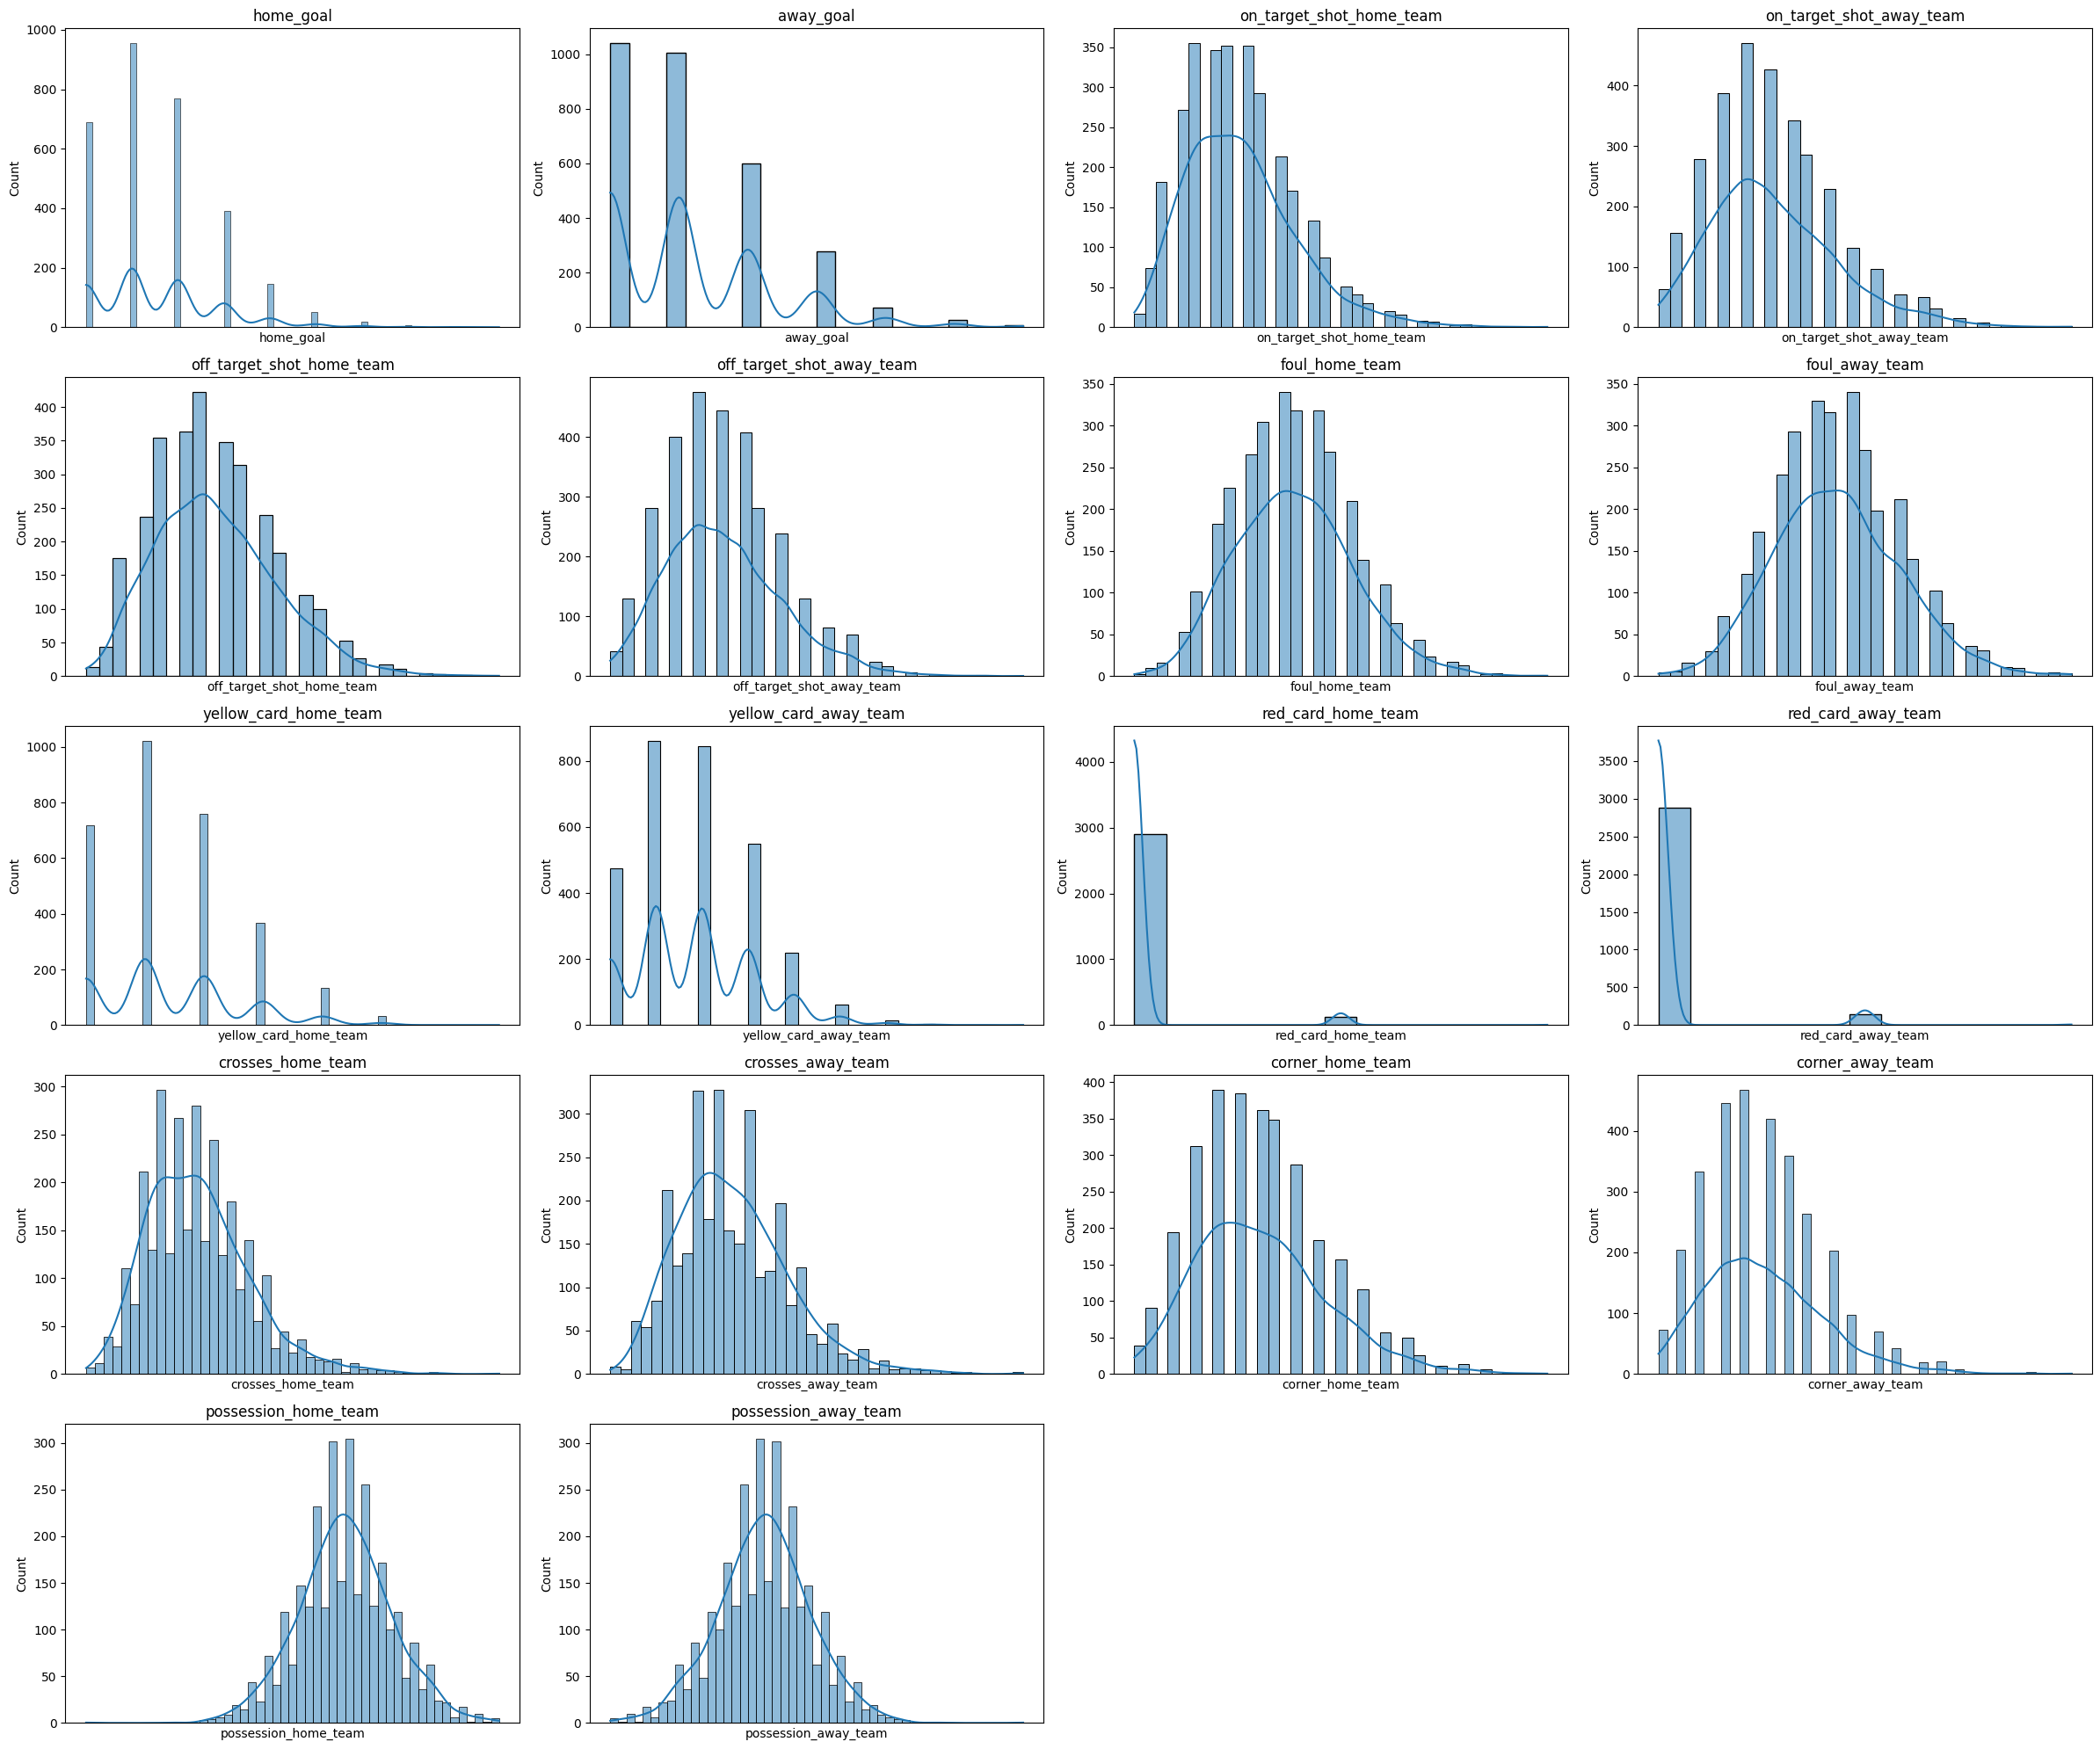

In [15]:
exclude_cols = ['country', 'home_team', 'away_team', 'league', 'season', 'date']
cols_to_visualize = [col for col in matches_df.columns if col not in exclude_cols]

plotter.seaborn_distribution_plots(matches_df[cols_to_visualize])

In [16]:
model_fitter = ModelFitter(matches_df)

matches_df['outcome'] = matches_df.apply(
    lambda x: model_fitter.get_result(x['home_goal'],x['away_goal']),
    axis = 1)

In [17]:
print("Outcome Counts:")
print(matches_df['outcome'].value_counts())

print("\nOutcome Percentages:")
print(matches_df['outcome'].value_counts(normalize=True) * 100)

plotter.plotly_histogram(matches_df, 'outcome')

Outcome Counts:
outcome
0    1646
1    1388
Name: count, dtype: int64

Outcome Percentages:
outcome
0    54.251813
1    45.748187
Name: proportion, dtype: float64


Immediately from here, we can see how many matches have been won, lost or drawn by the home team. There's definitely a majority of matches won by the home team. If we were to plot a correlation heatmap, we would find that many of these correlations are very weak. Whereas others are related to each others in the logical sense that a higher number of crosses for the home team, would mean a lower amount for the away team and so on.

Now, if we were to proceed like this, our model will most likely be 100% correct every time, why? Because in our dataset, besides the outcome/target variable, we also include the *home_goals* and *away_goals* variables. This means, the model can lazily pick only these two columns, and make the assumption that if there's more of one than the other, the team has won.

Therefore, to avoid this issue and based on the fact that we can see already that there is a majority of matches won by the home team, we will remove the *home_goals* and *away_goals* columns.


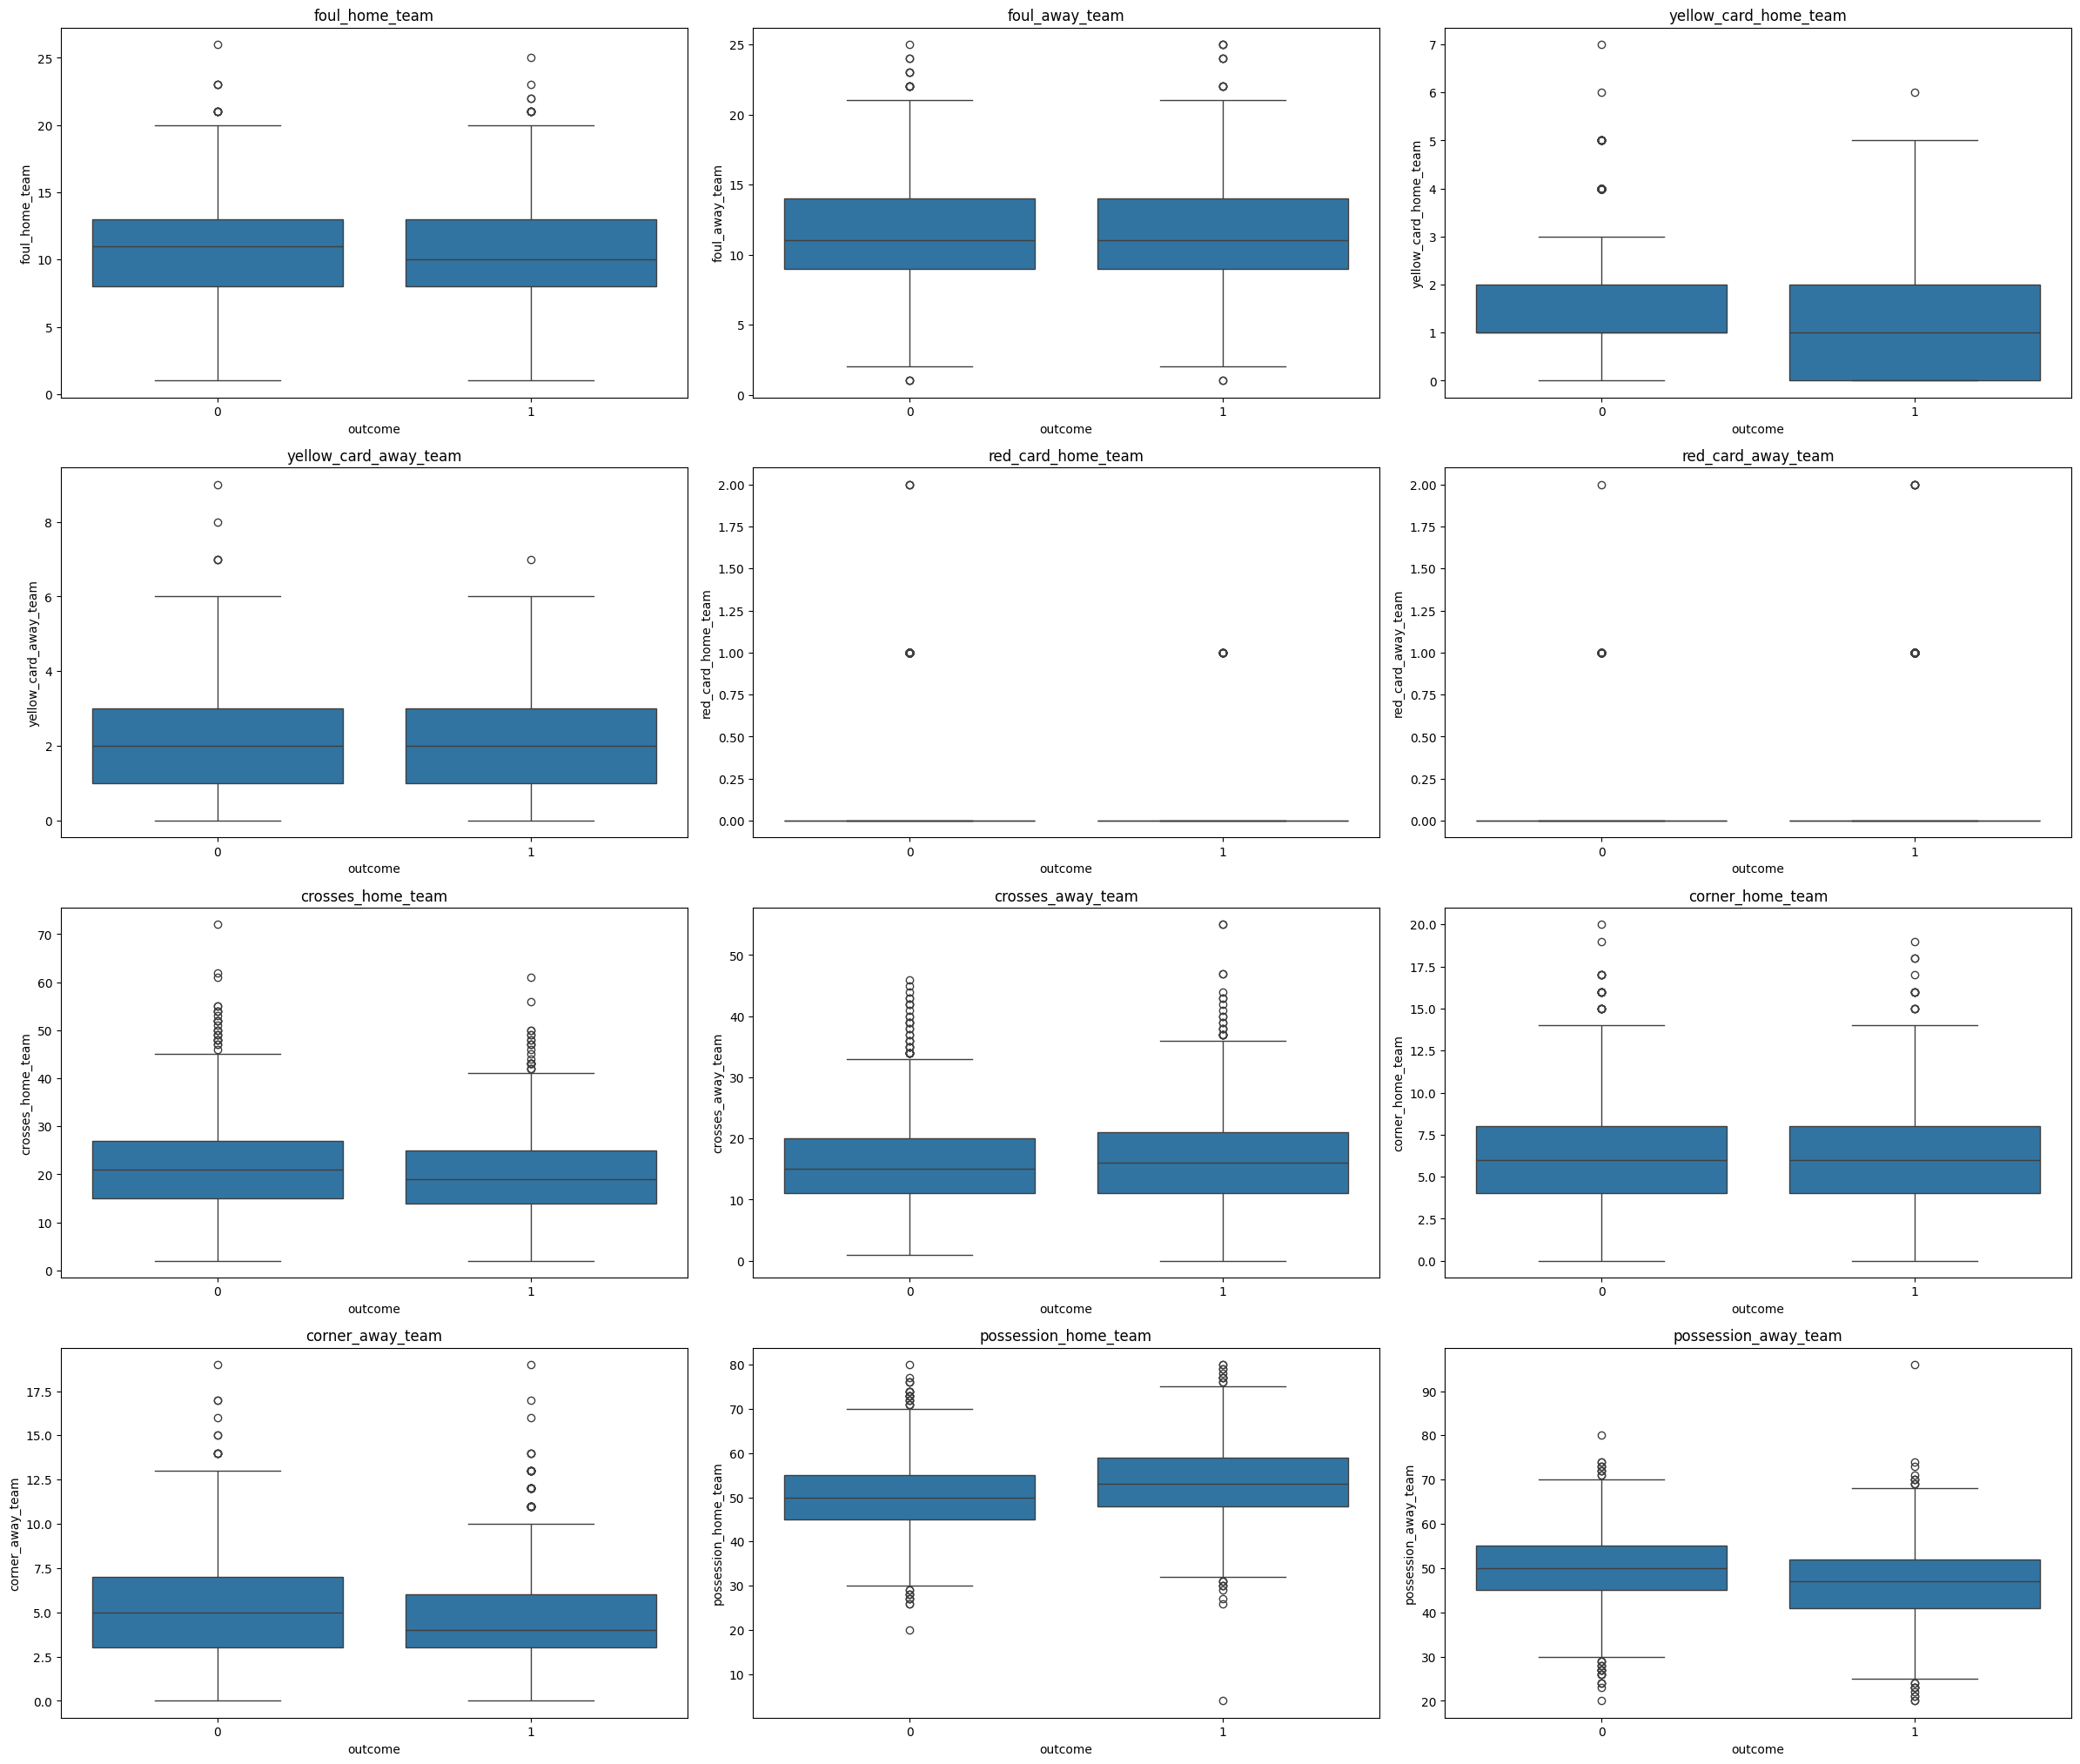

In [115]:
columns_pred = ['foul_home_team', 'foul_away_team','yellow_card_home_team', 'yellow_card_away_team', 'red_card_home_team','red_card_away_team','crosses_home_team', 'crosses_away_team','corner_home_team', 'corner_away_team', 'possession_home_team','possession_away_team','outcome']

# keep only relevant columns
matches_df = matches_df[columns_pred]
plotter.seaborn_box_plots(matches_df[columns_pred], x='outcome')

Because there's only a few matches with red cards, the distribution of their values is really abornmal, as well as the box plots with the target variable. We can also check how many outliers there are using z-scores, and remove those to reduce their impact 

In [116]:
cleaner.get_outliers_scores(matches_df[columns_pred].drop('outcome',axis=1))

foul_home_team             8
foul_away_team            12
yellow_card_home_team      3
yellow_card_away_team     21
red_card_home_team       124
red_card_away_team       155
crosses_home_team         32
crosses_away_team         22
corner_home_team          25
corner_away_team          17
possession_home_team       7
possession_away_team       7
dtype: int64

In [117]:
cleaner.remove_outliers(matches_df[columns_pred].drop('outcome',axis=1))

,foul_home_team,foul_away_team,yellow_card_home_team,yellow_card_away_team,red_card_home_team,red_card_away_team,crosses_home_team,crosses_away_team,corner_home_team,corner_away_team,possession_home_team,possession_away_team
0,16,11,3,0,0,0,24,9,6,6,55.0,45.0
1,11,9,0,0,0,0,21,7,7,5,66.0,34.0
2,13,12,0,2,0,0,15,19,1,8,46.0,54.0
3,14,13,2,1,0,0,15,27,6,10,52.0,48.0
4,11,13,0,1,0,0,16,16,7,8,52.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3035,16,10,2,0,0,0,10,21,6,7,51.0,49.0
3036,6,14,2,2,0,0,19,6,1,2,54.0,46.0
3037,15,11,1,2,0,0,12,10,8,6,49.0,51.0
3038,11,12,2,1,0,0,14,13,3,9,33.0,67.0


This is the number of outliers with values higher or lower than 3 z-scores, which we are going to remove. But there still are many columns. This might mean that we use some columns which have no particular impact on model evaluations/predictions, and therefore can be safely removed.

First let's create our X and y.

In [118]:
matches_df.columns

Index(['foul_home_team', 'foul_away_team', 'yellow_card_home_team',
       'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team',
       'crosses_home_team', 'crosses_away_team', 'corner_home_team',
       'corner_away_team', 'possession_home_team', 'possession_away_team',
       'outcome'],
      dtype='object')

In [119]:
X = matches_df.drop(['outcome'], axis=1)
y = matches_df['outcome']

In [120]:
x = add_constant(X.copy())
vic = pd.DataFrame()
vic['VIF'] = [variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
vic['features'] = x.columns
vic

,VIF,features
0,0.000000,const
1,1.211077,foul_home_team
2,1.244393,foul_away_team
3,1.205623,yellow_card_home_team
4,1.236712,yellow_card_away_team
5,1.011587,red_card_home_team
6,1.016714,red_card_away_team
7,1.424820,crosses_home_team
8,1.596003,crosses_away_team
9,1.560270,corner_home_team


All the values are way below 10, which means we likely don't have to worry about multicollinearity, exception made for the possession percentage, as that is absolutely related one to the other.

In [121]:
design_matrix = patsy.dmatrix('0 + possession_home_team:possession_away_team', data=X, return_type='dataframe')

X = pd.concat([X, design_matrix], axis=1)

# Linear Model for Matches prediction

Finally, we are ready to fit the model to the data.

In [122]:
model_fitter = ModelFitter(matches_df)

X_train, X_test, y_train, y_test = model_fitter.split_data(X, y, test_size=0.25)

grid_search, coefs_ = model_fitter.classification_model(X_train, y_train)

/home/alessio-pc/PycharmProjects/anespo-DA.4/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alessio-pc/PycharmProjects/anespo-DA.4/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

{'classifier__C': 10, 'classifier__fit_intercept': True, 'classifier__max_iter': 1000, 'classifier__solver': 'newton-cg', 'classifier__tol': 0.1}


In [123]:
log_reg_model = grid_search.best_estimator_

test_results, y_pred = model_fitter.evaluate_classification_model_test(log_reg_model, X_test, y_test)
test_scores_df = pd.DataFrame(test_results)

train_results, y_train_pred = model_fitter.evaluate_classification_model_train(log_reg_model, X_train, y_train)
train_scores_df = pd.DataFrame(train_results)

In [129]:
y_probs = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plotter.plot_roc_auc_curve(fpr, tpr, roc_auc)

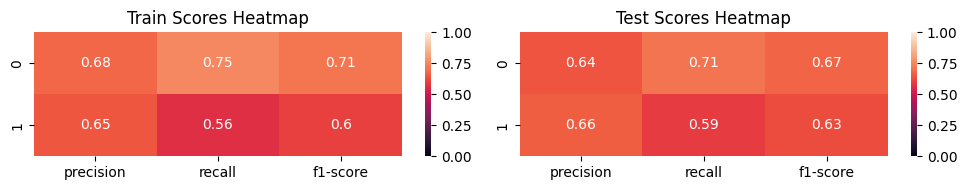

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(10,2))

axes[0].set_title('Train Scores Heatmap')
sns.heatmap(train_scores_df.iloc[:-1, :-3].T, annot=True, ax=axes[0], vmin=0, vmax=1)
axes[1].set_title('Test Scores Heatmap')
sns.heatmap(test_scores_df.iloc[:-1, :-3].T, annot=True, ax=axes[1], vmin=0, vmax=1)

plt.tight_layout()
plt.show()

In [126]:
class_labels = sorted(set(y_pred))

confusion_matrix_test = model_fitter.evaluate_classification_confusion(log_reg_model, X_train, y_train, X_test, y_test, use_train_predictions=False)

plotter.plot_confusion_matrix(confusion_matrix_test, class_labels)

This looks way too good to be true, our model has most certainly overfit the data, and this is due to the high number of columns/features that we used.

Let's look at some ways to reduce the number of features. We will use 3 methods to understand which features are the most important for our model:

- Random Forest Classifier
- Permutation Importance
- Principal Component Analysis  

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

# Random Forest Classifier Method
rf_model = RandomForestClassifier(n_estimators=1000, criterion='log_loss', random_state=42)
rf_model.fit(X_train, y_train)
print()
print(f"Random Forest Feature Importance:")
print(rf_model.feature_importances_)

# Permutation Importance Method
result = permutation_importance(log_reg_model, X_test, y_test, n_repeats=10, random_state=42)
print()
print(f"Permutation Importance:")
print(result.importances_mean)

# PCA Method
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X)
print()
print(f"PCA Model explained variance ratio:")
print(pca.explained_variance_ratio_)


Random Forest Feature Importance:
[0.10033541 0.10140336 0.05620536 0.06074923 0.01284334 0.01400067
 0.13807068 0.12371525 0.09060012 0.08595843 0.07859907 0.07771118
 0.05980791]

Permutation Importance:
[-0.0002635  -0.00869565  0.01646904  0.00092227  0.00790514  0.01291173
  0.05915679  0.04137022  0.00803689  0.01607378  0.02028986  0.01462451
  0.00118577]

PCA Model explained variance ratio:
[9.78463538e-01 1.12568364e-02 4.53052566e-03 3.05929790e-03
 1.05182696e-03 7.30026184e-04 4.22828601e-04 3.07085436e-04
 1.02020654e-04 6.95542368e-05 3.64026355e-06]


Ultimately, it seems like all of our methods define that our first 2 columns are the only one that are *really* needed by the model to predict, as the others have values close to 0. The most conservative approach would be choosing the Random Forest Classifier, but in this case, since all values beside the first 2 columns are all close to 0, we will just use PCA instead.

To use PCA, we will just use X_rf instead of X_train, and redo the whole process.

In [128]:
stop

NameError: name 'stop' is not defined

In [132]:
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

top_n = 6
selected_features = X.columns[indices[:top_n]]
print(selected_features)
X_rf = X[selected_features]


Index(['crosses_home_team', 'crosses_away_team', 'foul_away_team',
       'foul_home_team', 'corner_home_team', 'corner_away_team'],
      dtype='object')


In [133]:
X_rf, X_test, y_train, y_test = model_fitter.split_data(X_rf, y, test_size=0.25)

grid_search, coefs_ = model_fitter.classification_model(X_rf, y_train)

{'classifier__C': 0.1, 'classifier__fit_intercept': True, 'classifier__max_iter': 1000, 'classifier__solver': 'newton-cholesky', 'classifier__tol': 1}


In [134]:
log_reg_model = grid_search.best_estimator_

test_results, y_pred = model_fitter.evaluate_classification_model_test(log_reg_model, X_test, y_test)
test_scores_df = pd.DataFrame(test_results)

train_results, y_train_pred = model_fitter.evaluate_classification_model_train(log_reg_model, X_rf, y_train)
train_scores_df = pd.DataFrame(train_results)

In [135]:
y_probs = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plotter.plot_roc_auc_curve(fpr, tpr, roc_auc)

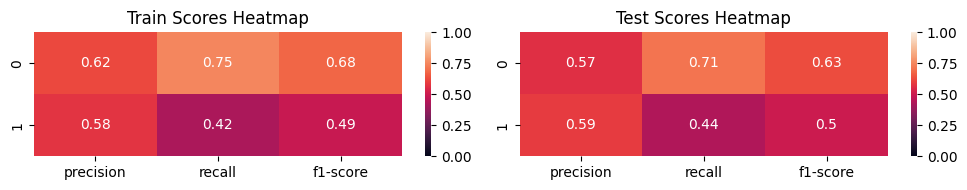

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(10,2))

axes[0].set_title('Train Scores Heatmap')
sns.heatmap(train_scores_df.iloc[:-1, :-3].T, annot=True, ax=axes[0], vmin=0, vmax=1)
axes[1].set_title('Test Scores Heatmap')
sns.heatmap(test_scores_df.iloc[:-1, :-3].T, annot=True, ax=axes[1], vmin=0, vmax=1)

plt.tight_layout()
plt.show()

In [137]:
class_labels = sorted(set(y_pred))

confusion_matrix_test = model_fitter.evaluate_classification_confusion(log_reg_model, X_rf, y_train, X_test, y_test, use_train_predictions=False)

plotter.plot_confusion_matrix(confusion_matrix_test, class_labels)

In [138]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [139]:
log_model = sm.GLM(y_train, X_rf, family=sm.families.Binomial())
log_results = log_model.fit()
print(log_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 2275
Model:                            GLM   Df Residuals:                     2269
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1502.9
Date:                Sat, 04 Nov 2023   Deviance:                       3005.8
Time:                        18:30:26   Pearson chi2:                 2.27e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05203
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
crosses_home_team    -0.0512      0.00

In [140]:
x_log_train, x_log_test, y_log_train, y_log_test = train_test_split(
    X_rf, y, test_size=0.30, random_state=4, stratify=y
)
model = sm.MNLogit(y_log_train, x_log_train)
results = model.fit()
print(results.summary())

ValueError: Found input variables with inconsistent numbers of samples: [2275, 3034]

t-sne 

dimensionality reduction